In [1]:
# This code comes from https://disassemble-channel.com/pytorch-rnn/

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# pytorch library

import torch
from torch import nn,optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torchvision import transforms
from torchinfo import summary

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


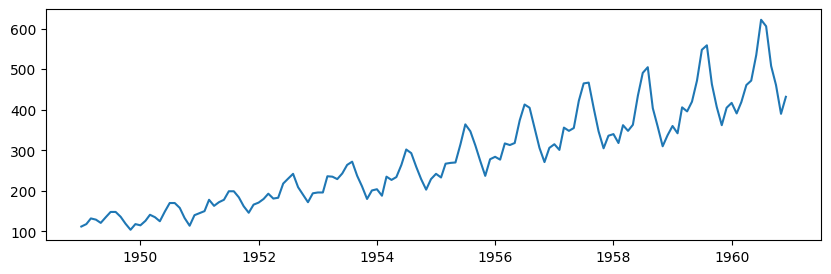

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv", index_col='Month', parse_dates=True)
plt.figure(figsize=(10, 3))
plt.plot(df)
display(df)

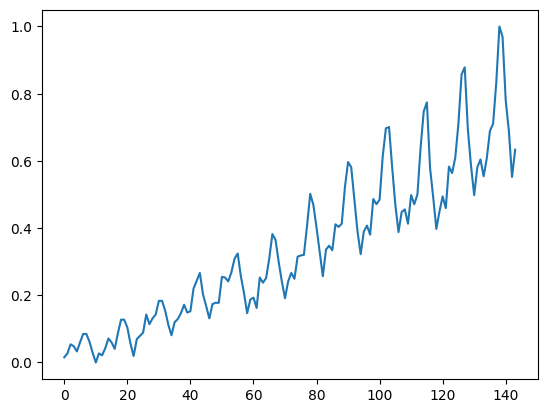

In [3]:
df = df.values.reshape(-1, 1).astype("float32")
trans = MinMaxScaler()
df_trans = trans.fit_transform(df)
plt.plot(df_trans)

In [4]:
df_train, df_test = train_test_split(df_trans, test_size=.3, shuffle=False)

window_size = 10

n_train = len(df_train) - window_size
train = np.zeros((n_train, window_size, 1))
train_labels = np.zeros((n_train, 1))

for i in range(n_train):
    train[i] = df_train[i:i+window_size].reshape(-1, 1)
    train_labels[i] = df_train[i+window_size]

train = torch.tensor(train, dtype=torch.float32)
labels = torch.tensor(train_labels, dtype=torch.float32)
dataset = torch.utils.data.TensorDataset(train, labels)
train_loader = DataLoader(dataset, batch_size=4, shuffle=True)

In [5]:
class MyRNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(MyRNN, self).__init__()

        self.input_size = input_size
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_size)

    def forward(self, x):
        y_rnn, h = self.rnn(x)
        y = self.fc(y_rnn[:, -1, :])

        return y

In [6]:
n_inputs = 1
n_outputs = 1
n_hidden = 64
n_layers = 1

In [7]:
model = MyRNN(n_inputs, n_outputs, n_hidden, n_layers)
summary(model)

Layer (type:depth-idx)                   Param #
MyRNN                                    --
├─RNN: 1-1                               4,288
├─Linear: 1-2                            65
Total params: 4,353
Trainable params: 4,353
Non-trainable params: 0

In [8]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_history = []
epochs = 1000

Epoch: 0, Loss_train: 0.020523375350698505


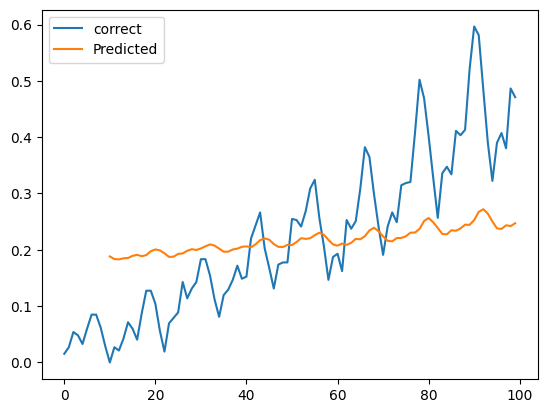

Epoch: 100, Loss_train: 0.0013766706040611177


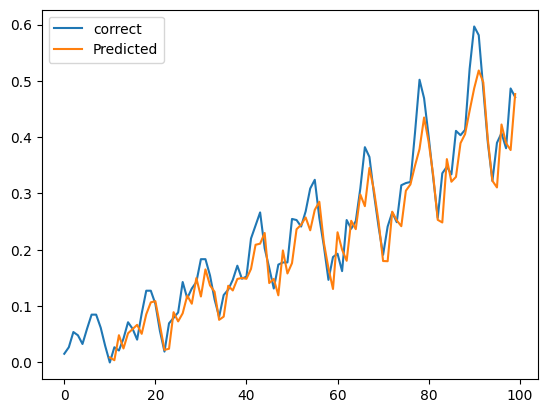

Epoch: 200, Loss_train: 0.0016290095126074132


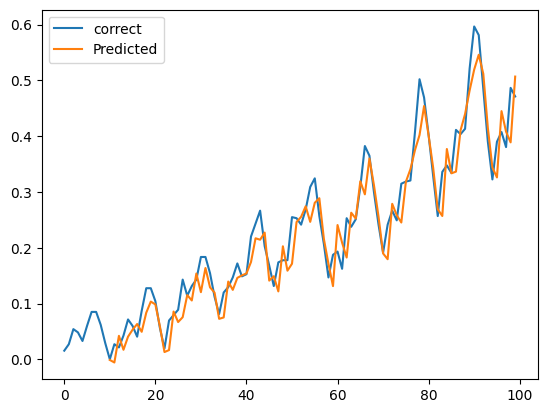

Epoch: 300, Loss_train: 0.0014049814698924108


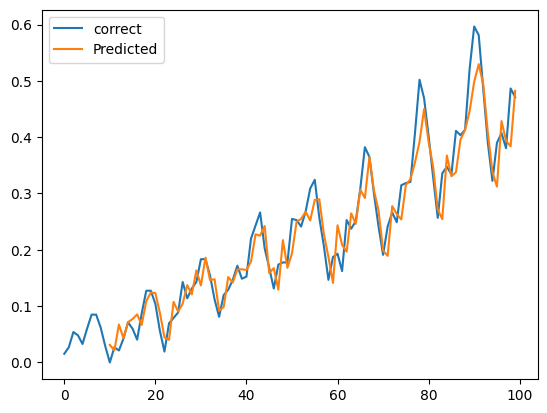

Epoch: 400, Loss_train: 0.001449716047120645


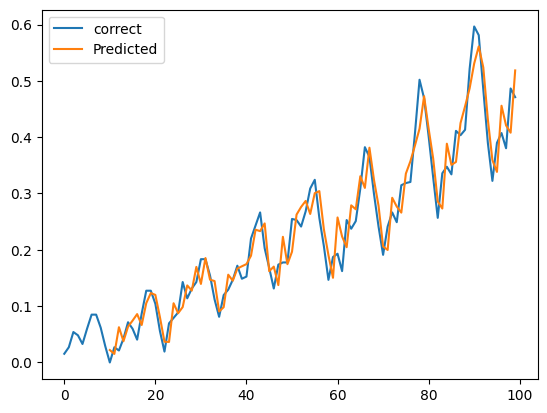

Epoch: 500, Loss_train: 0.001432069551969028


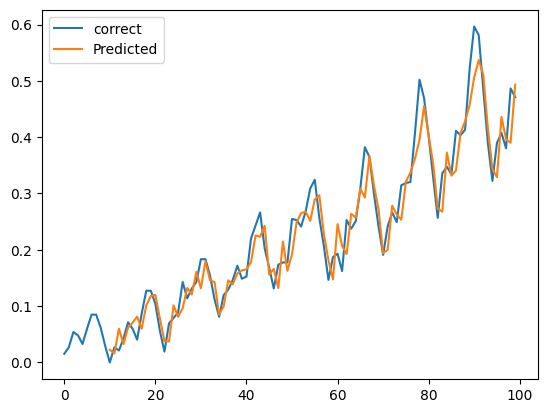

Epoch: 600, Loss_train: 0.0013527237726679152


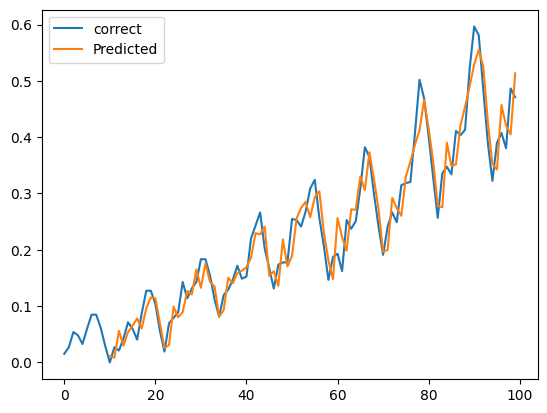

Epoch: 700, Loss_train: 0.0012323405983055557


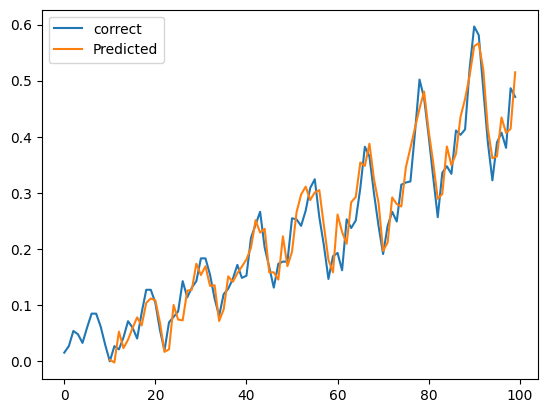

Epoch: 800, Loss_train: 0.0004455261375329903


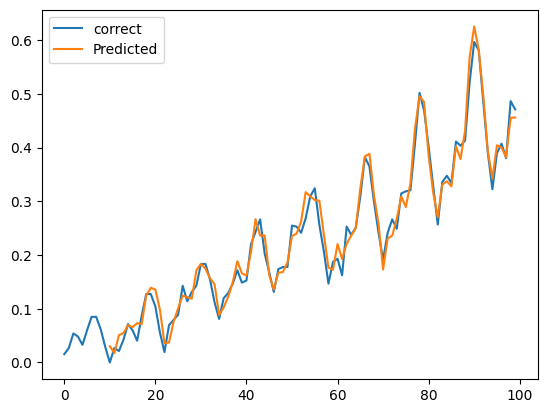

Epoch: 900, Loss_train: 0.0003970371661758374


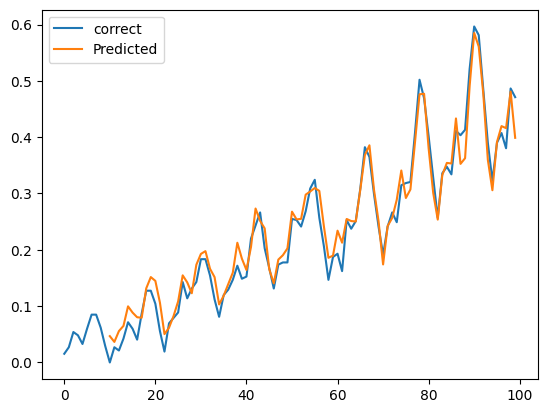

Epoch: 1000, Loss_train: 0.00025930215182914094


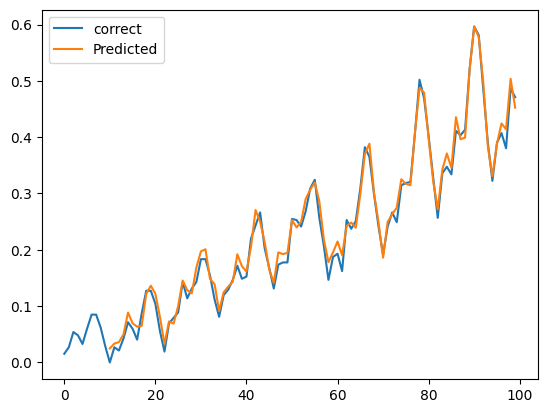

In [9]:
for i in range(epochs+1):
    model.train()
    tmp_loss = .0
    for j, (X, y) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        tmp_loss += loss.item()
    tmp_loss /= j+1
    loss_history.append(tmp_loss)

    if i % 100 == 0:
        print(f'Epoch: {i}, Loss_train: {tmp_loss}')
        input_train = list(train[0].reshape(-1))
        predicted_train_plot = []
        model.eval()
        for k in range(n_train):
            x = torch.tensor(input_train[-window_size:])
            x = x.reshape(1, window_size, 1)
            y = model(x)

            if k <= n_train - 2:
                input_train.append(train[k+1, 9].item())
            predicted_train_plot.append(y[0].item())

        plt.plot(range(len(df_train)), df_train, label='correct')
        plt.plot(range(window_size, window_size+len(predicted_train_plot)),
                 predicted_train_plot, label='Predicted')
        plt.legend()
        plt.show()